# Seoul Bike Sharing Demand Analysis

**Group 2: Xiao Hu, Vinky Wang, Izzy Zhang**

## 1. Introduction

### 1.1 Motivation

The bike-sharing system has made public transportation cleaner and more convenient as citizens can get access to bicycles across the city. As of 2020, 3200 bikes were being offered in Seoul, South Korea [1]. However, imbalance in demand and bicycles supplied can create problems for both users and system operators. Predicting bicycle usage helps guide companies to control the amount of bikes to deploy. In our project, we will be using different environmental variables as predictors for the hourly count of bike rentals.

We started with data cleaning and exploratory analysis which resulted in 10 predictor varibles and 1 response variable. Due to the poorly fitted poisson model, we proceeded with fitting using the negative binomial model. We were able to obtain a relatively well predicting model using negative binomial. 

The dataset was collected by the website of “South Korea Public Holidays” [2] and used by Sathishkumar et al. to test different data mining techniques and to make inferences and predictions [1].

### 1.2 Dataset Description

In [1]:
# Load packages
library(tidyverse)
library(lubridate)
library(corrplot)
library(car)
library(repr)
library(broom)
library(MASS)
library(rsample)
library(DHARMa)
library(AER)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


corrplot 0.92 loaded

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: lmtest

Loading required package: zoo


We first read data from its source. 

In [2]:
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
bike = read.csv(url,check.names=F)

**Variable Information:**

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour (our response variable)
- Hour - Hour of the day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

For easier understanding, we breifly clean the data by giving names to columns, changing data types, and making sense of the date variable. We will do more tidying in the next section. 

In [3]:
# Rename columns
colnames(bike) <- c("date", "count", "hour", "temp", "humidity", "windspeed", "visibility", "dew", "solar", "rain", "snow", "seasons", "holiday", "functioning")

# Convert variable into different classes
bike <- bike %>%
  mutate(date = as.POSIXct(date, format = "%d/%m/%Y"), # date
         month =  factor(months(date)),      # add months variable
         seasons = factor(seasons), # factor
         holiday = factor(holiday), # factor
         functioning = factor(functioning)) # factor
head(bike)

,date,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,functioning,month
,<dttm>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes,December
4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes,December
6,2017-12-01,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes,December


## 2. Methods and Results

### 2.1 Exploratory Data Analysis

#### 2.1.1 Data Cleaning

We noticed that count becomes zero when `functioning == "No"`. So we proceeded with removing all rows when the bike sharing system is not functioning and the `functioning` column. 

In [4]:
## remove functioning == "No" rows from the dataset. 
bike <- bike[which(bike$functioning == "Yes"),]
bike <- subset(bike, select = -functioning)

We reordered levels in `seasons` and `holiday`, so the reference level in `seasons` is `Spring` and the reference level in holiday is `No Holiday`.

In [5]:
bike$seasons <- relevel(bike$seasons, ref = "Spring")
bike$holiday <- relevel(bike$holiday,ref = "No Holiday")

We remove the `date` and `month` column since we do not plan to do time series analysis. We also put `hour` into three categories--"morning", "afternoon" and "night". 

In [6]:
bike <- subset(bike, select = -c(date, month))
## changing hour into time of the day
bike <- bike %>% 
   mutate(tod = case_when(((hour < 13)&(hour > 3)) ~ "Morning",
                                 hour < 21 ~ "Afternoon",
                                 TRUE ~ "Night"))
bike$tod <- as.factor(bike$tod)
head(bike)

,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,tod
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Afternoon
2,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Afternoon
3,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Afternoon
4,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Afternoon
5,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Morning
6,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Morning


After cleaning the data, we split the dataframe into training and testing for further analyses. We chose a proportion of 70/30. 

In [7]:
set.seed(34567)
bike_split <- initial_split(bike, prop = 0.7)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

#### 2.1.2 Multi-collinearity
We have tested for multi-collinearity in the whole dataset in our proposal. Now we will identify variables in the training set that are correlated with one another and select a subset of the dataset that minimizes multicollinearity. 

,temp,humidity,windspeed,visibility,dew,solar,rain,snow
temp,1.00000000,0.1539553,-0.03197670,0.03636107,0.9136303,0.36161865,0.05607276,-0.21245692
humidity,0.15395525,1.0000000,-0.33148340,-0.55201175,0.5296681,-0.45802066,0.24539100,0.10985523
windspeed,-0.03197670,-0.3314834,1.00000000,0.18717004,-0.1696710,0.32598825,-0.03217295,-0.01145729
visibility,0.03636107,-0.5520118,0.18717004,1.00000000,-0.1778320,0.16187554,-0.17153928,-0.12838257
dew,0.91363031,0.5296681,-0.16967095,-0.17783202,1.0000000,0.10404535,0.13379372,-0.14603775
solar,0.36161865,-0.4580207,0.32598825,0.16187554,0.1040453,1.00000000,-0.07705423,-0.07186494
rain,0.05607276,0.2453910,-0.03217295,-0.17153928,0.1337937,-0.07705423,1.00000000,0.01653452
snow,-0.21245692,0.1098552,-0.01145729,-0.12838257,-0.1460377,-0.07186494,0.01653452,1.00000000


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"use" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"use" is not a graphical parameter”
Warning message in title(title, ...):
“"use" is not a graphical parameter”


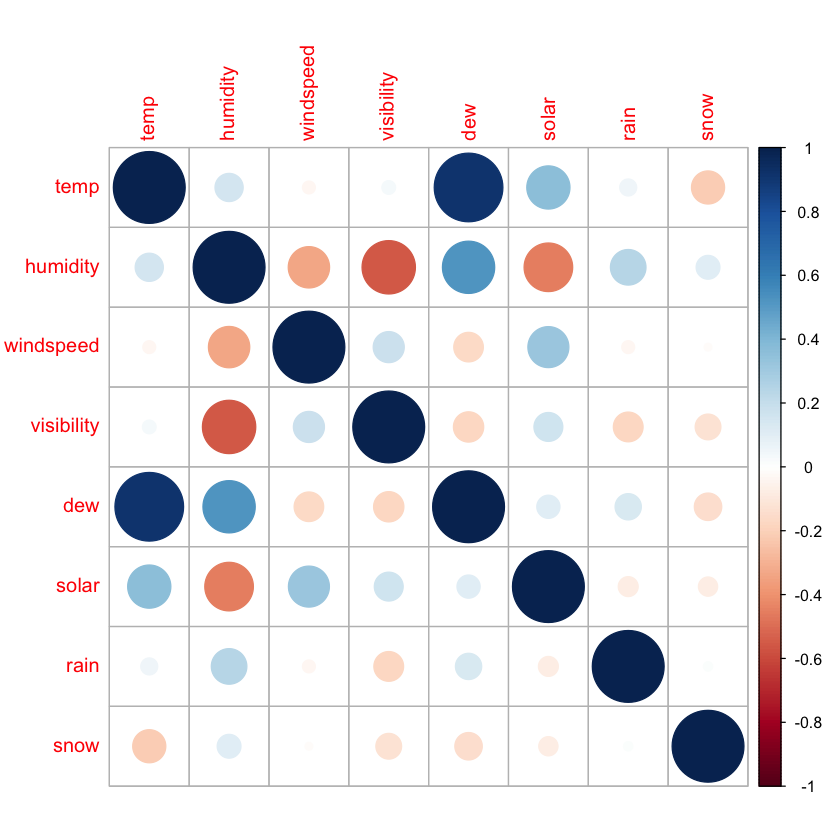

In [8]:
# Select only numeric environmental variables
bike_var <- bike_training %>%
  dplyr::select(c(temp, humidity, windspeed, visibility, dew, solar, rain, snow))

# Correlation matrix
cor_matrix <- cor(bike_var)
cor_matrix

# Correlation plot
corrplot(cor_matrix, use = "complete.obs", method="circle")

Figure 1. Correlation plot for predictor variables. 

We see from the correlation plot a strong positive correlation between `dew` and `temp`, a relatively strong positive correlation between `dew` and `humidity`, a strong negative correlation between `visibility` and `humidity`, and a relatively strong negative correlation between `solar` and `humidity`. 

In order to address correlation, we will use variance inflation factor (VIF) as a criteria for variable selection before model fitting. 

Lastly, we visualize all the varibles to help guide our analysis. 

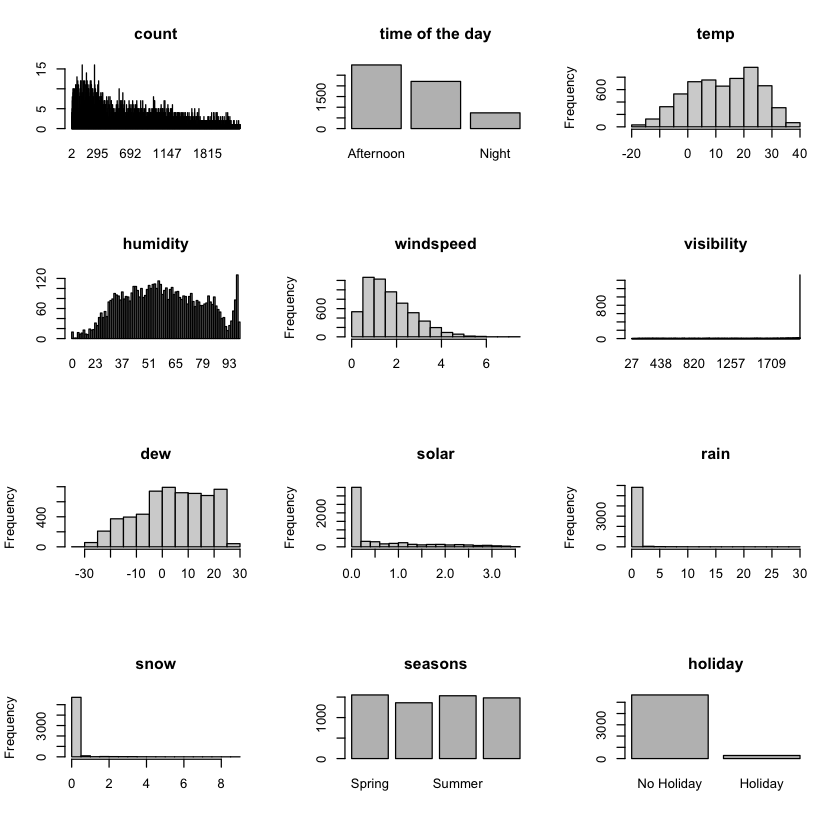

In [9]:
## plot the variables
par(mfrow=c(4,3))
barplot(table(bike_training$count), main = "count")
barplot(table(bike_training$tod), main = "time of the day")
hist(bike_training$temp, main = "temp", xlab = "")
barplot(table(bike_training$humidity), main = "humidity")
hist(bike_training$windspeed, main = "windspeed", xlab = "")
barplot(table(bike_training$visibility), main = "visibility")
hist(bike_training$dew, main = "dew", xlab = "")
hist(bike_training$solar, main = "solar", xlab = "")
hist(bike_training$rain, main = "rain", xlab = "")
hist(bike_training$snow, main = "snow", xlab = "")
barplot(table(bike_training$seasons), main = "seasons")
barplot(table(bike_training$holiday), main = "holiday")

Figure 2. Visualization for all variables.

Note: 
- `visibility` has many data with values of 2000
- `solar`, `rain` and `snow` has many data with values of 0

### 2.2 Model Selection

#### Poisson Regression

Since the response variable of bike rentals correspond to count data, we will first fit a full Poisson model with all variables in the data and evaluate its performance. 

$$
P(Y_i = y_i, \lambda_i, \theta) = \frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}  \quad \text{for} \  y_i \in \{0, 1, \cdots \}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$V[Y_i] = \lambda_i$$

Let's explore the distribution of bike rentals. 

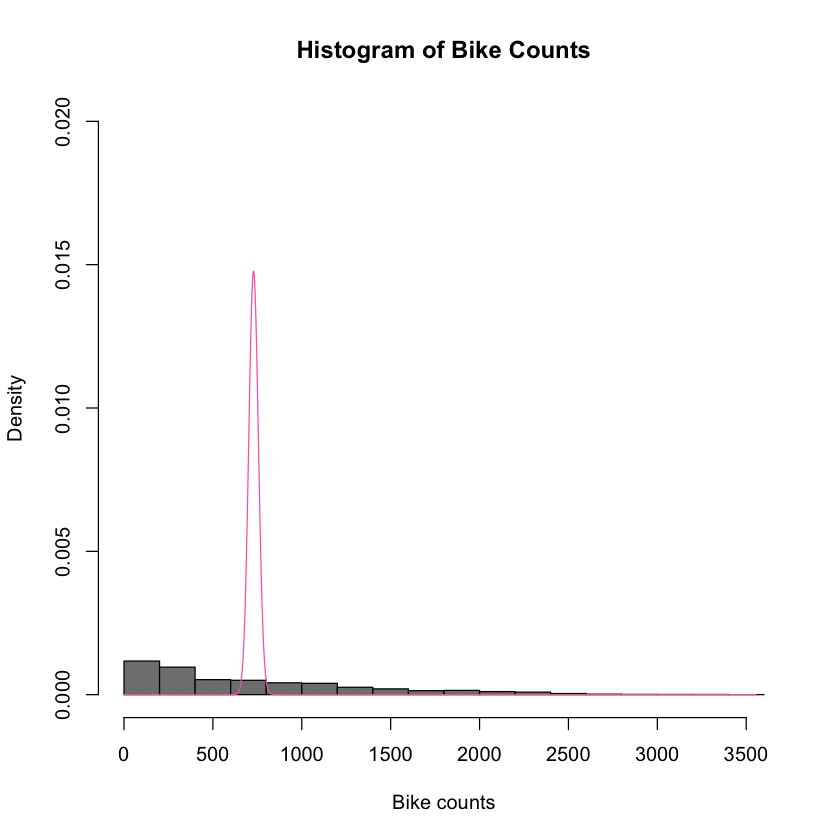

In [10]:
hist(bike$count, freq=FALSE, col=grey(0.5), ylim=c(0, 0.02), main="Histogram of Bike Counts", xlab="Bike counts")
  lines(0:max(bike$count), dpois(0:max(bike$count), mean(bike$count)), col="hotpink")

Figure 3. Response variable distribution and poisson density. 

It appears that the pink line corresponding to a Poisson density with mean equal to that of the observed bike counts places more probability mass around 750 bike rentals whereas most of the actual observed bike counts are around 250 and under. This may be an early indication that the Poisson distribution is not appropriate for the dataset. 

We will proceed to fitting a Poisson distribution and check for further indications. 

In [37]:
poisson_model <- glm(formula = count~tod + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday + rain,
                     family = "poisson",
                     data = bike_training)
tidy(poisson_model) %>% mutate_if(is.numeric, round, 4)
glance(poisson_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.8012,0.0035,1921.4181,0
todMorning,-0.1669,0.0012,-135.7446,0
todNight,0.2460,0.0015,167.3137,0
temp,0.0394,0.0001,432.7134,0
humidity,-0.0125,0.0000,-329.3632,0
windspeed,0.0742,0.0005,138.9279,0
visibility,-0.0001,0.0000,-50.9880,0
solar,-0.0933,0.0007,-129.6666,0
snow,-0.1051,0.0026,-40.9624,0


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
3189013,5924,-709546.4,1419121,1419214,1372149,5911,5925


In [12]:
deviance(poisson_model)/poisson_model$df.residual
dispersiontest(poisson_model)

[1] 232.1349


	Overdispersion test

data:  poisson_model
z = 1.0186, p-value = 0.1542
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  113445.9 


The `residual deviance/df` is greater than 1 which suggests overdispersion. We can also use the `dispersiontest` from the `AER` package which tests the null hypothesis of equal mean and variance (i.e. equidispersion) against the alternative hypothesis $V[Y_i] = \lambda_i + c*f(\lambda_i)$ where the constant $c<0$ corresponds to underdispersion and $c>0$ corresponds to overdispersion. Effectively, this is testing $H_0: c = 0$ versus $H_1: c \neq 0$ using the t-statistic. Since the $c$ is estimated to be 200.87 and p-value < 0.05, this suggests evidence of overdispersion.

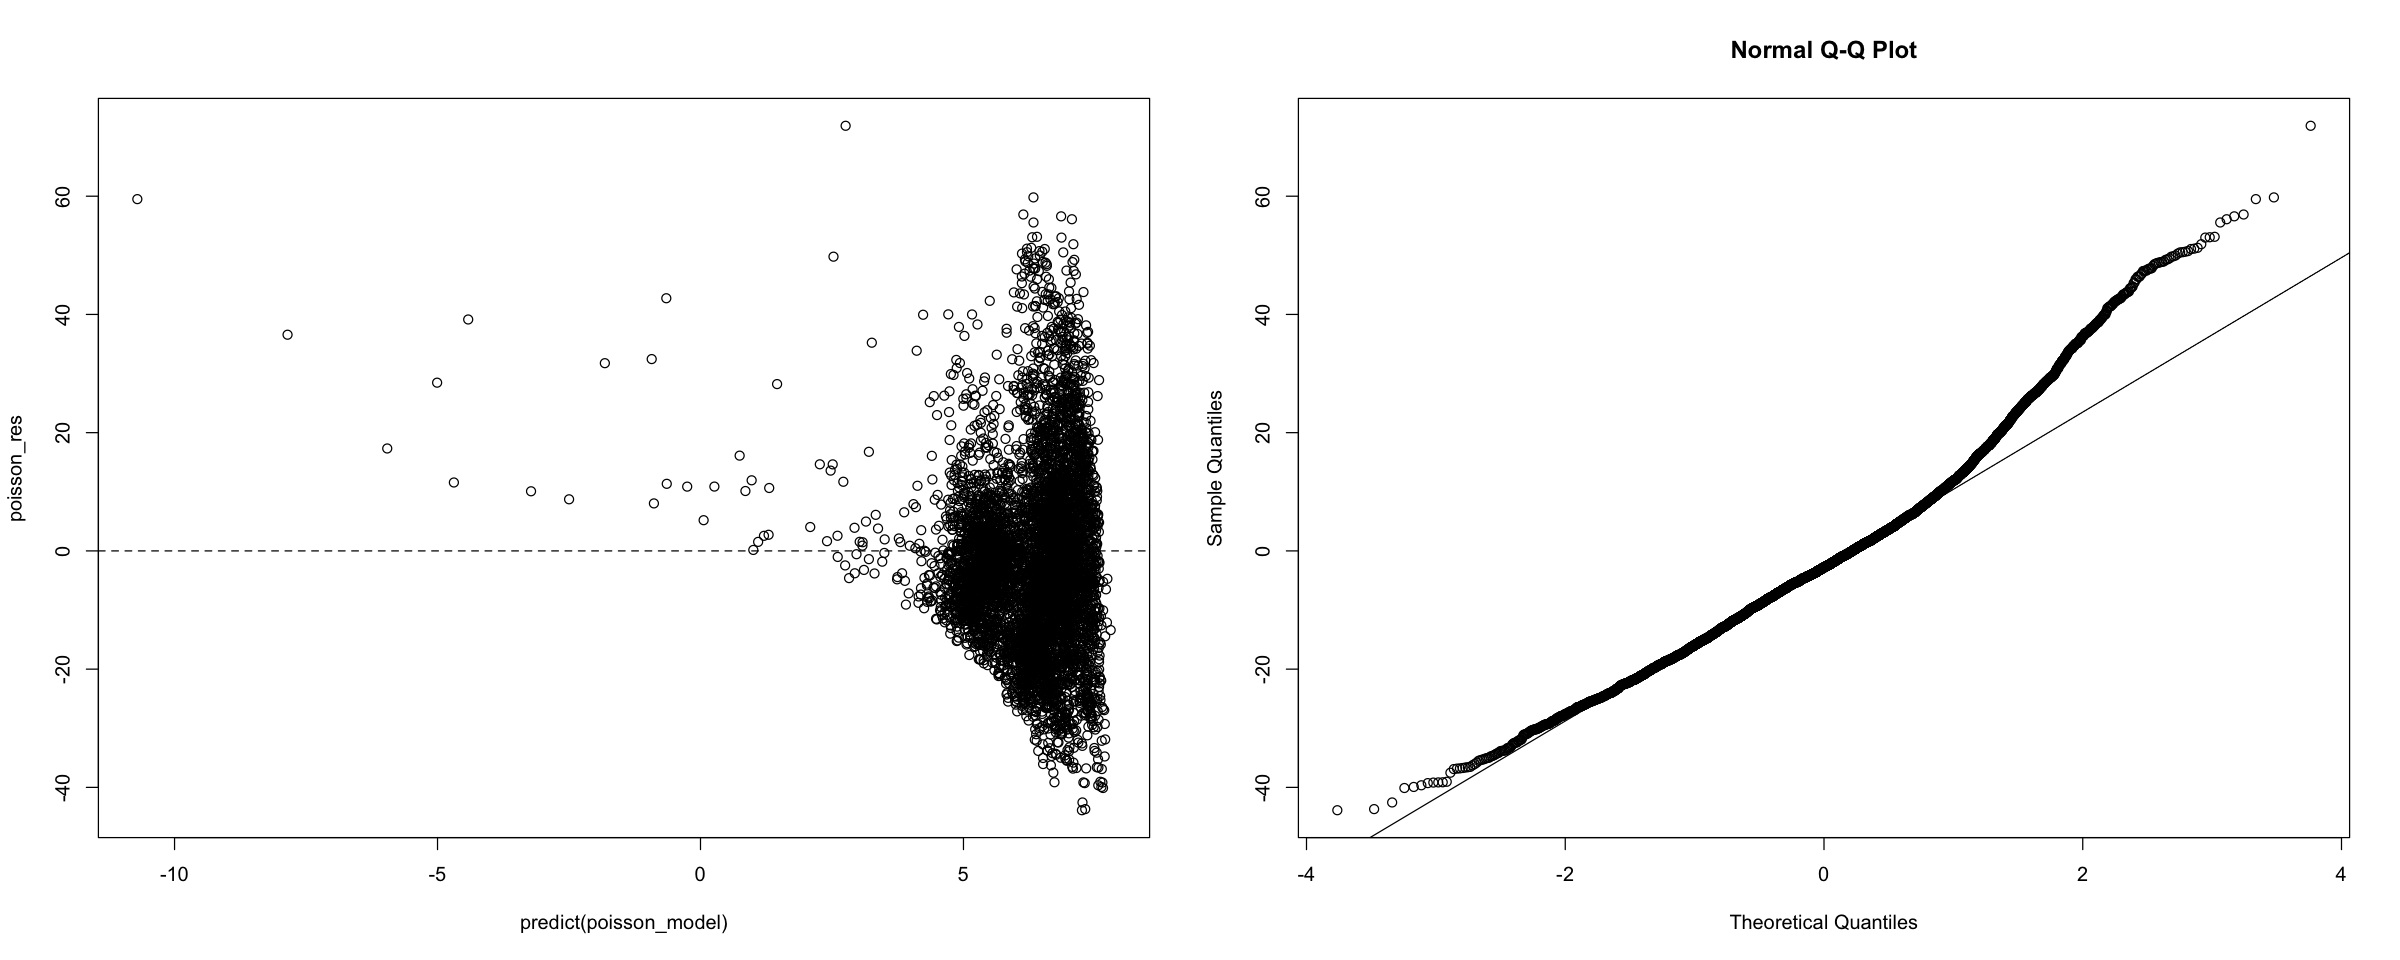

In [13]:
 # Residual plots
{options(repr.plot.width=20, repr.plot.height=8)
par(mfrow=c(1,2))
poisson_res <- residuals(poisson_model, type="deviance")
plot(predict(poisson_model), poisson_res)
abline(h=0, lty=2)
qqnorm(poisson_res)
qqline(poisson_res)
}

Figure 4. Residuals vs fitted and QQ plot for poisson model. 

Furthermore, there appears to be funnel-like pattern in the reisduals which suggest that the Poisson distribution is not appropriate for this dataset. 

#### Negative Binomial Regression

To account for extra dispersion in Poisson models, we will use the **Negative Binomial** distribution instead of the Poisson distribution.

$$P(Y_i = y_i, \lambda_i, \theta) = \frac{\Gamma(\theta + y_i)}{\Gamma(y_i +1)\Gamma(\theta)} 
\left (\frac{\theta}{\theta + \lambda_i}\right)^{\theta}  \left (\frac{\lambda_i}{\theta + \lambda_i}\right)^{y_i}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$V[Y_i] = \lambda_i + \lambda_i^2/\theta$$

Like Poisson, the negative binomial regression can be used to fit counts data. Moreover, the negative binomial model can be used when the variance of data is substancially higher than the mean. The overdispersion with respect to the Poisson distribution in this case is given by $\lambda_i^2/\theta$, which approaches 0 as $\theta$ increases.

Since there is a convergent issue when we include `rain` in the negative binomial model, which might be caused by zero-inflation and high variance in the column of `rain`. Therefore, we decided to drop `rain` in our negative binomial model. Then we also did a multicolinearity check, and `dew` is the variable with highest VIF value. After we removing `dew`, all variables have a VIF value lower than 5.

In [14]:
# Variance inflation factor selection with all numerical variables except `rain`
model_vif1 <- glm.nb(count~ temp + humidity + windspeed + visibility + solar + snow + dew, data = bike_training)
vif(model_vif1)

temp   humidity  windspeed visibility      solar       snow        dew 
 80.901739  18.179354   1.192188   1.563648   1.984232   1.087186 106.392299

In [15]:
# Variance inflation factor selection after removing `dew`
model_vif2 <- glm.nb(count~ temp + humidity + windspeed + visibility + solar + snow, data = bike_training)
vif(model_vif2)

temp   humidity  windspeed visibility      solar       snow 
  1.538870   2.306941   1.188904   1.554703   1.878139   1.083340

We fitted a negative binomial model with all variables except `rain` and `dew` as our full model.

$$log(\lambda_i) = \beta_0 + \beta_1todMorning + \beta_2todNight + \beta_3temp + \beta_4humidity + \beta_5windspeed + \beta_6visibility + \beta_7solar + \beta_8snow+\beta_9seasonsAutumn + \beta_{10}seasonsSummer +\beta_{11}seasonsWinter +  \beta_{12}holidayHoliday$$

In [36]:
nbinomial_model <- glm.nb(
  formula = count~tod + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday,
  data = bike_training
)
tidy(nbinomial_model)  %>% mutate_if(is.numeric, round, 4)
glance(nbinomial_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.8206,0.0694,98.2764,0.0000
todMorning,-0.0583,0.0212,-2.7443,0.0061
todNight,0.2816,0.0296,9.5033,0.0000
temp,0.0464,0.0017,27.4109,0.0000
humidity,-0.0166,0.0007,-23.7158,0.0000
windspeed,0.0390,0.0098,3.9616,0.0001
visibility,0.0000,0.0000,-2.0115,0.0443
solar,-0.0594,0.0152,-3.8984,0.0001
snow,-0.0749,0.0221,-3.3827,0.0007


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<logLik>,<dbl>,<dbl>,<dbl>,<int>,<int>
12295.25,5924,-42816.02,85660.04,85753.66,6405.581,5912,5925


In [17]:
# Goodness-of-fit test
gof.pvalue = 1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual)
print(paste0("p-value of LRT: ", round(gof.pvalue,4)))

[1] "p-value of LRT: 0"


The likelihood ratio test comparing the "saturated model" vs. the current model shows a p-value smaller than 0.05, which means there remains a significant lack of fit.

In [18]:
# Dispersion
dis <- nbinomial_model$theta
print(paste0("Dispersion parameter: ", round(dis,2)))

[1] "Dispersion parameter: 2.07"


The overdispersion parameter with respect to the Poisson distribution is 2.07.

We then use backward selection method to select an optimal subset of variables which minimizes the value of AIC.

In [19]:
# AIC stepwise selection
AIC_nbinomial_model <- stepAIC(nbinomial_model, k = log(nrow(bike_training)),
                                  direction = "backward", trace = 1)

Start:  AIC=85744.97
count ~ tod + temp + humidity + windspeed + visibility + solar + 
    snow + seasons + holiday

             Df   AIC
- visibility  1 85741
<none>          85745
- snow        1 85746
- solar       1 85751
- windspeed   1 85751
- holiday     1 85797
- tod         2 85850
- humidity    1 86223
- seasons     3 86323
- temp        1 86405

Step:  AIC=85740.56
count ~ tod + temp + humidity + windspeed + solar + snow + seasons + 
    holiday

            Df   AIC
<none>         85741
- snow       1 85741
- solar      1 85744
- windspeed  1 85746
- holiday    1 85792
- tod        2 85844
- seasons    3 86314
- humidity   1 86334
- temp       1 86402


Variables selected by AIC stepwise selection are: tod, temp, humidity, windspeed, solar, snow, holiday, and seasons

In [34]:
tidy(AIC_nbinomial_model)  %>% mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.7227,0.0504,133.4841,0.0000
todMorning,-0.0595,0.0212,-2.8003,0.0051
todNight,0.2794,0.0296,9.4301,0.0000
temp,0.0465,0.0017,27.4534,0.0000
humidity,-0.0158,0.0006,-27.4024,0.0000
windspeed,0.0376,0.0098,3.8289,0.0001
solar,-0.0540,0.0150,-3.6046,0.0003
snow,-0.0733,0.0221,-3.3103,0.0009
seasonsAutumn,0.2769,0.0263,10.5337,0.0000


After getting the best reduced model, we will use the residual v.s prediction plot and QQ plot to diagnose the reduced model.

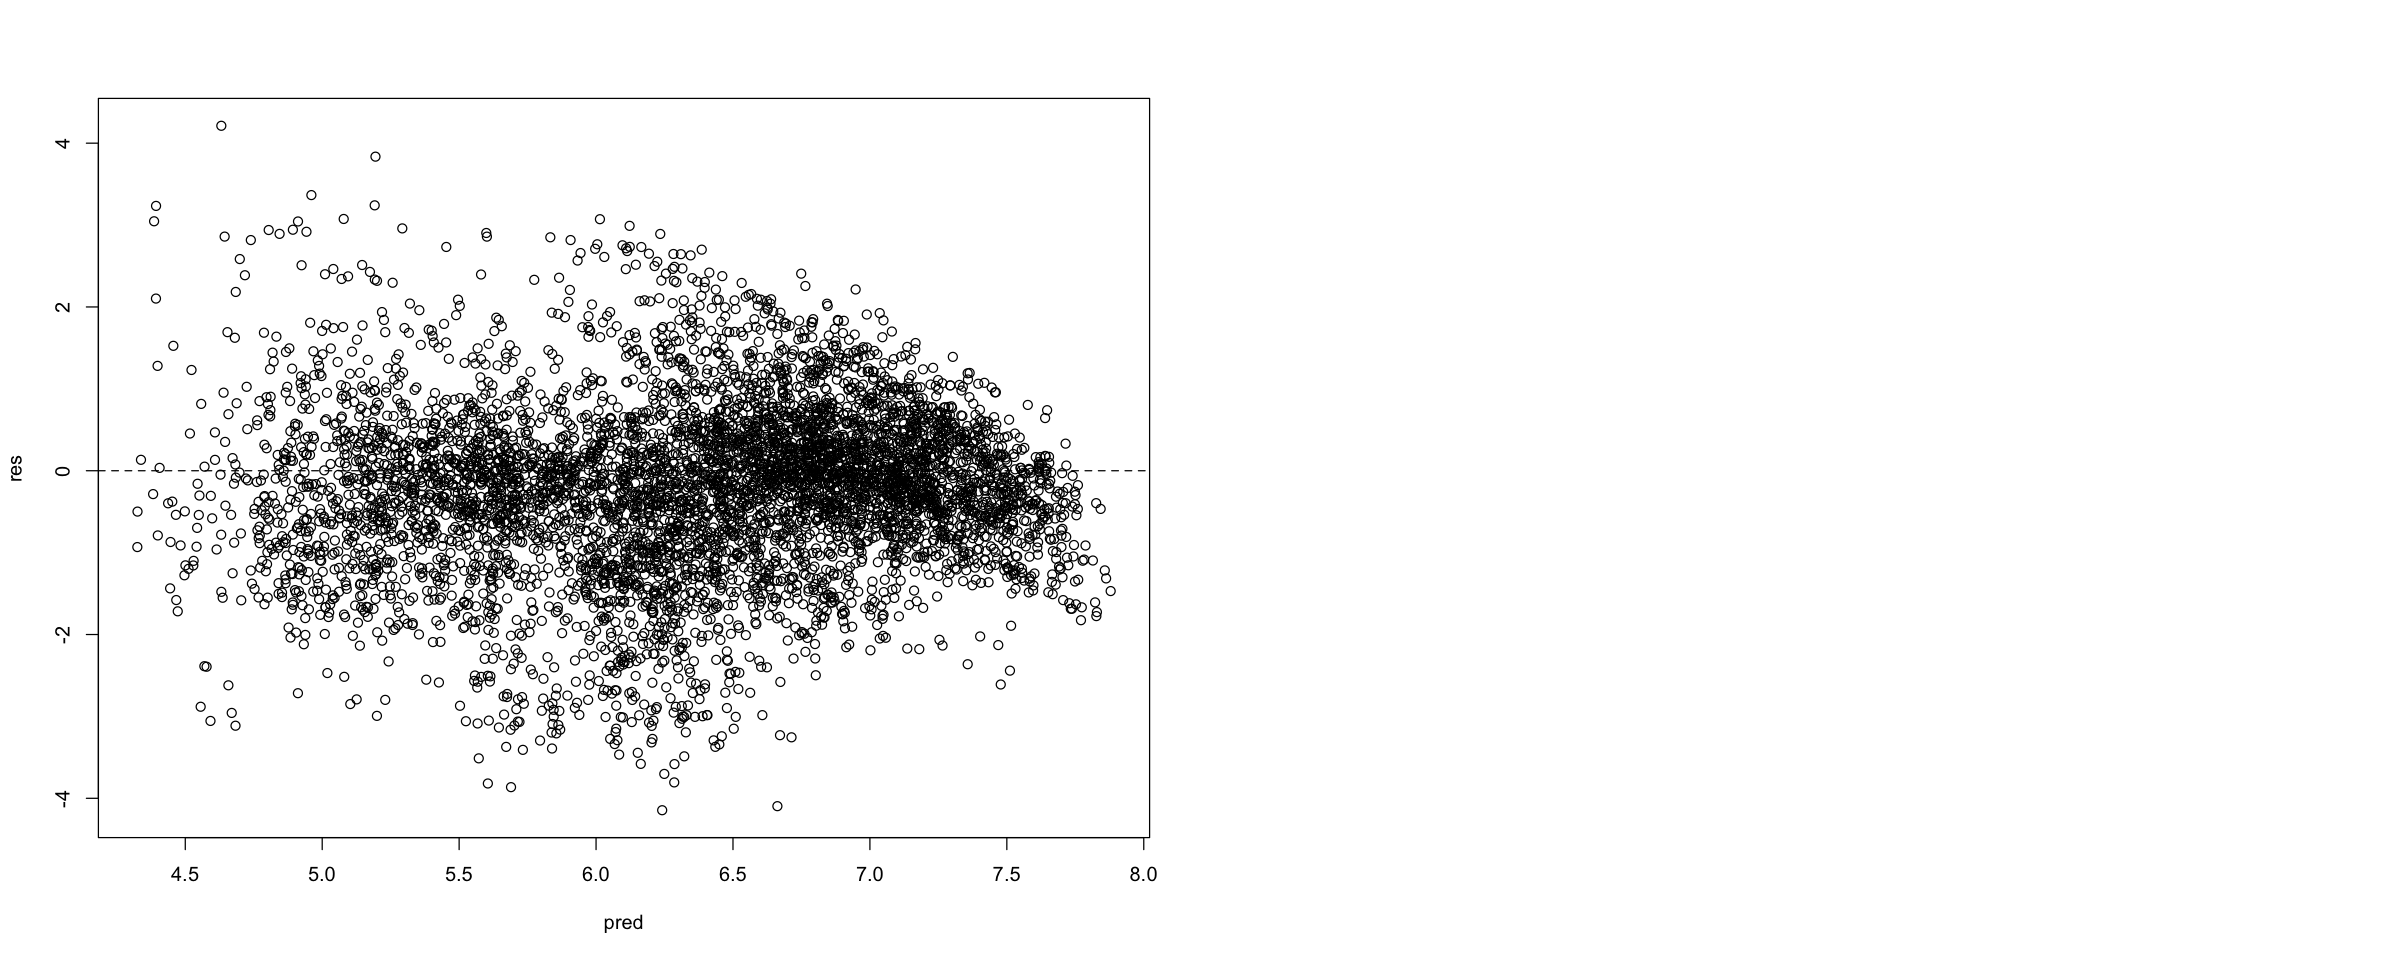

In [21]:
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow=c(1,2))
res <- residuals(AIC_nbinomial_model, type="deviance")
pred <- predict(AIC_nbinomial_model)
plot(pred, res)
abline(h=0, lty=2)
#qqnorm(res)
#qqline(res)

Figure 5. Residuals vs fitted and QQ plot for Negative Binomial model. 

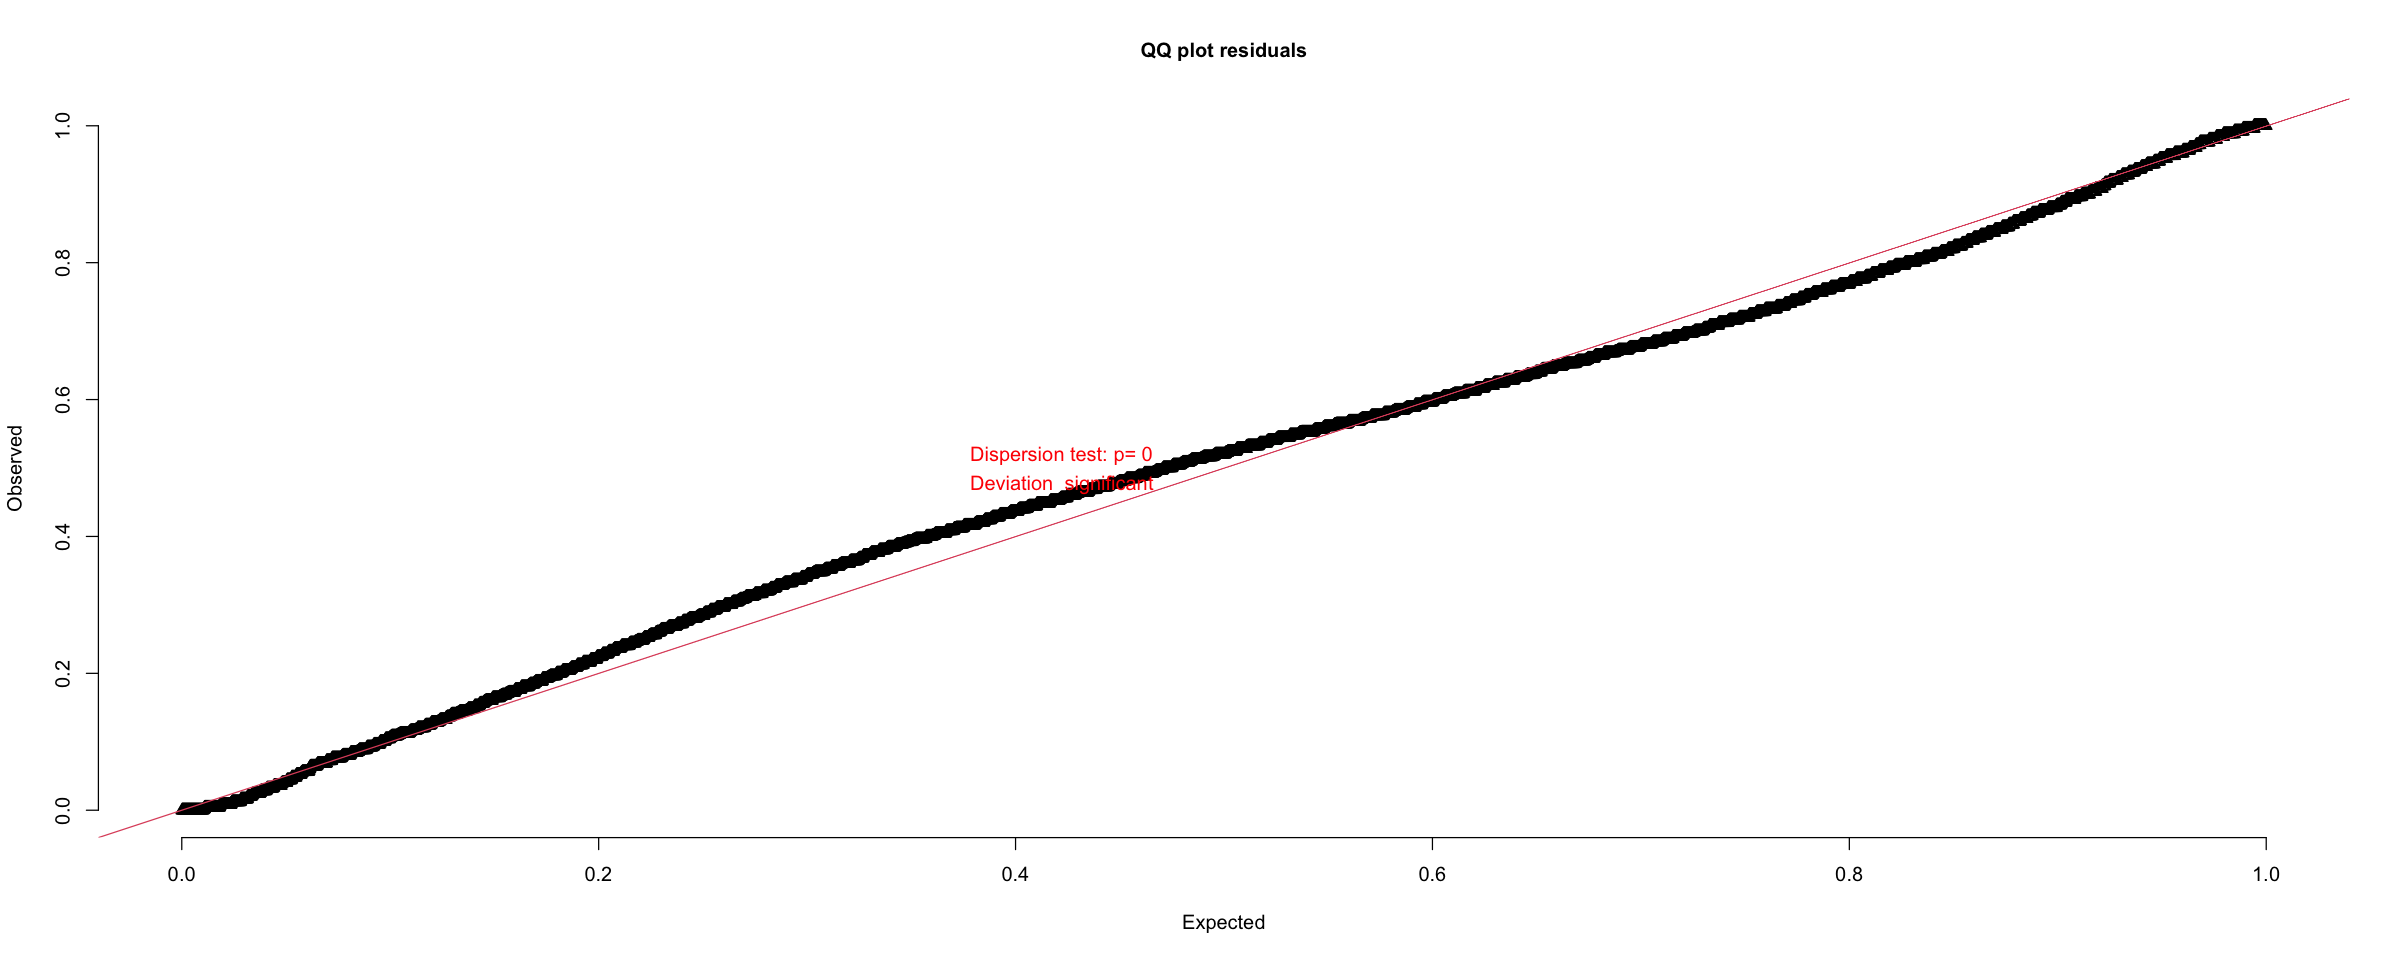

In [22]:
options(repr.plot.width=20, repr.plot.height=8)
n_sim <- 250
simulationOutput <- simulateResiduals(fittedModel = AIC_nbinomial_model, n = n_sim)
plotQQunif(simulationOutput,testOutliers = FALSE,testDispersion = TRUE, testUniformity = FALSE)

There is still a funnel-shape pattern in the residual plot, but it has a great improvement compared with the plot from Poisson regression. The Q-Q plot looks normal with a light tail.

##### Compare all three models

In [23]:
t <- as.data.frame(rbind(glance(nbinomial_model),glance(AIC_nbinomial_model),glance(poisson_model)))
rownames(t) <- c("nbinomial","AIC_nbinomial","Poisson")
t  %>% dplyr::select(-c(df.residual,nobs,df.null))  %>% 
        mutate(n_coef = c(length(coef(nbinomial_model)),length(coef(AIC_nbinomial_model)),length(coef(poisson_model)))) #%>% 
       # mutate(overdispersion = c(nbinomial_model$theta,AIC_nbinomial_model$theta)) #%>% 
       # mutate(gof.pvalue = c(1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual),
       #                      1 - pchisq(AIC_nbinomial_model$deviance, AIC_nbinomial_model$df.residual)))

,null.deviance,logLik,AIC,BIC,deviance,n_coef
,<dbl>,<logLik>,<dbl>,<dbl>,<dbl>,<int>
nbinomial,12295.25,-42816.02,85660.04,85753.66,6405.581,13
AIC_nbinomial,12287.52,-42818.16,85662.31,85749.24,6405.834,12
Poisson,3189012.61,-709546.44,1419120.87,1419214.49,1372149.166,14


In [24]:
library(lmtest)
lrtest(poisson_model,nbinomial_model)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,-709546.44,NA,NA,NA
2,14,-42816.02,0,1333461,0


In [25]:
anova(nbinomial_model,AIC_nbinomial_model)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
tod + temp + humidity + windspeed + solar + snow + seasons + holiday,2.065666,5913,-85636.31,,NA,NA,NA
tod + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday,2.066977,5912,-85632.04,1 vs 2,1,4.270212,0.03878609


There are 12 coefficients in the reduced model. Overdispersion parameter in the reduced model is slightly larger than that in the full model, which implies smaller dispersion with respect to Poisson regression. 

Since all three models are nested, we tested them in pairs. P-value of likelihood ratio test between negative binomial model and poisson model is smaller than 0.05, which indicates that the nagetive binomial model is significantly better than the poisson model under 5% significance level.Similarly, the reduced model is significantly better than the reduced model, and the reduced model has lowest values of both AIC and BIC. Therefore, we selected the reduce model as our best model, and we will evaluate its prediction performance in the next section.

### 2.3 Model Evaluation

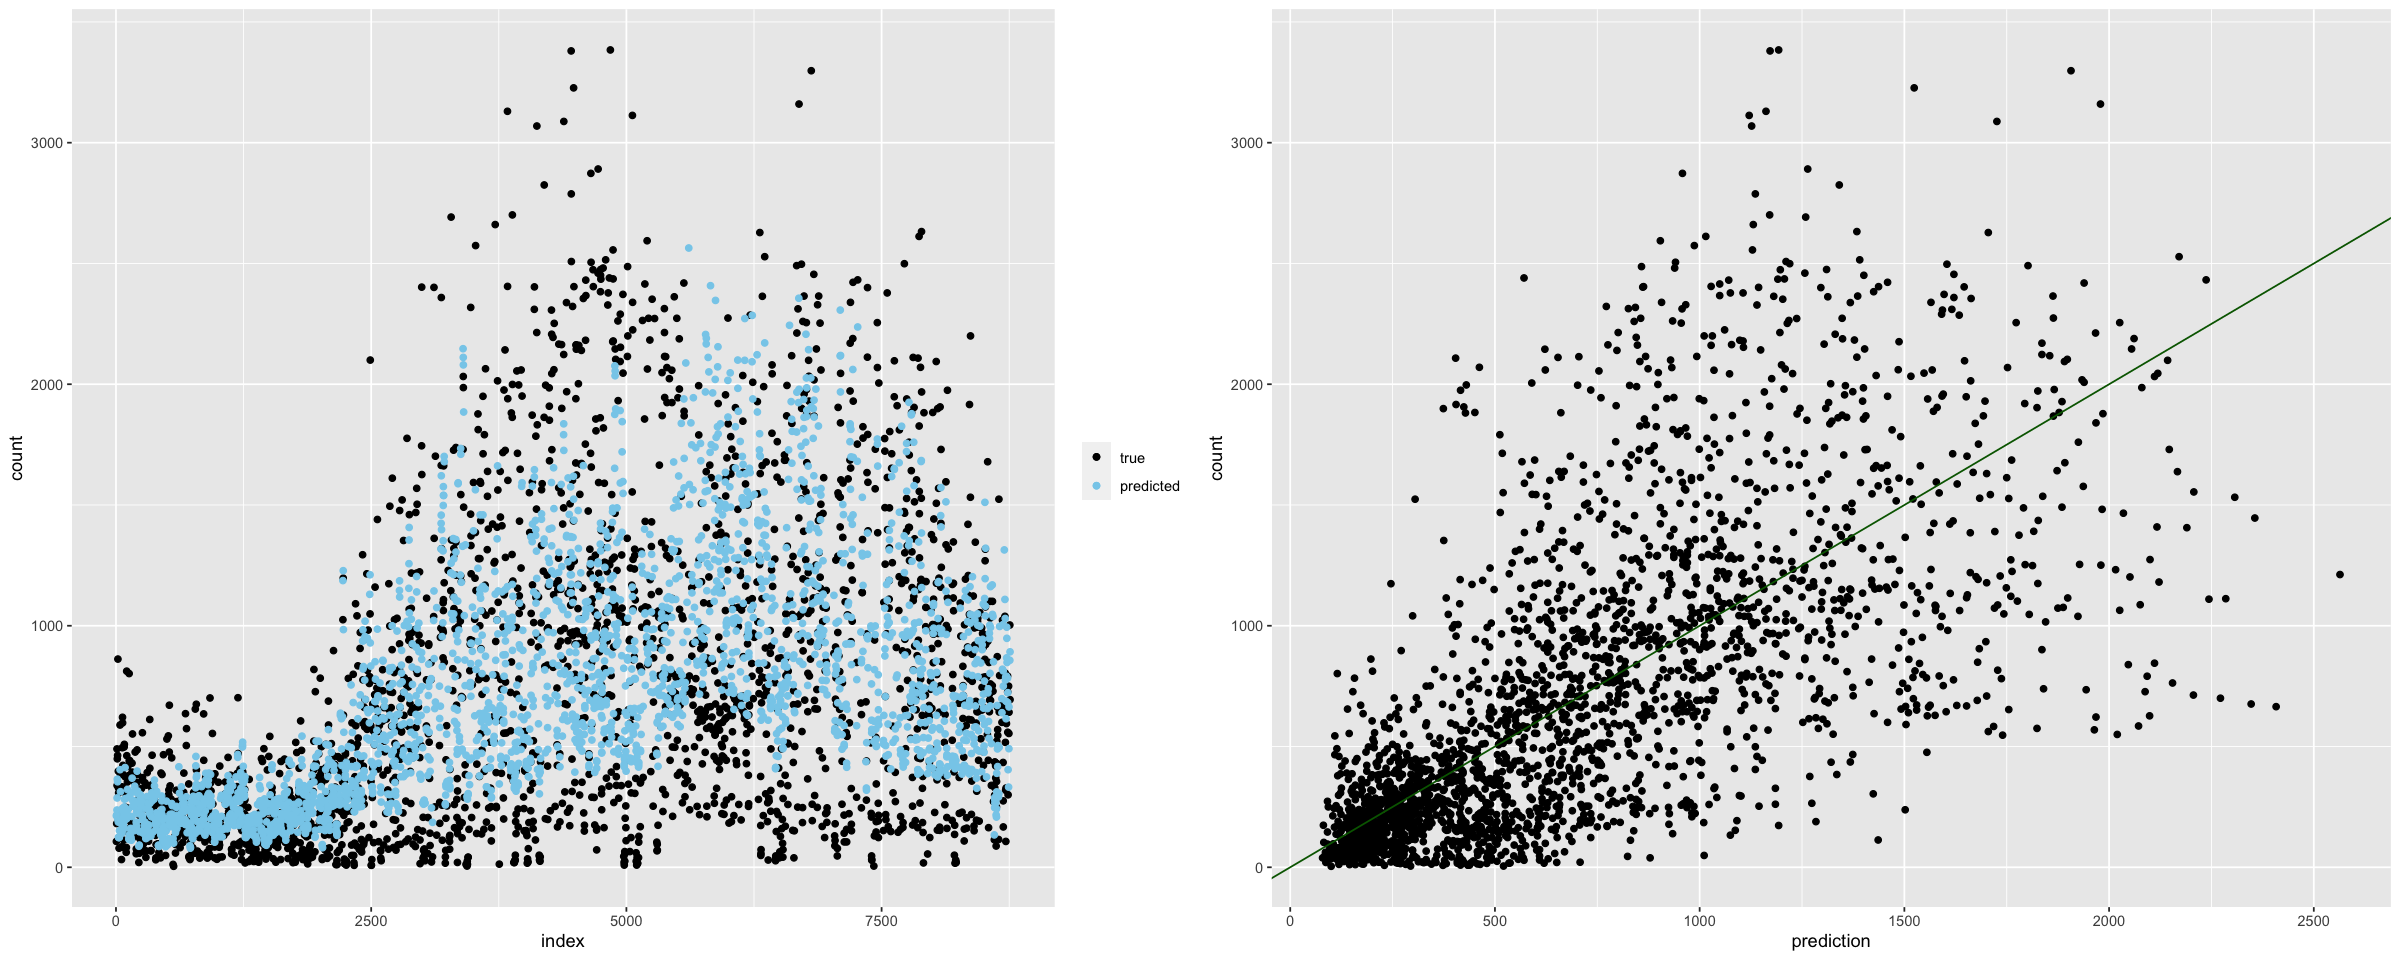

In [26]:
# plot predicted values and actual values
bike_testing$index <- as.numeric(row.names(bike_testing))
bike_testing$pred <- predict(AIC_nbinomial_model,newdata = bike_testing, type = 'response' )
options(repr.plot.width=20, repr.plot.height=8)
g1 <- bike_testing  %>% ggplot(aes(x = index,y = count,color = "true"))  + 
                    geom_point() + 
                    geom_point(aes(y = round(pred,0), x = index,color = "predicted"))+
                    scale_colour_manual("", 
                              breaks = c("true", "predicted"),
                              values = c("black", "sky blue"))
g2 <- bike_testing  %>% ggplot(aes(x = round(pred,0),y = count))  + 
                    geom_point() +
                    xlab("prediction") +
                    geom_abline(intercept = 0, slope = 1, col = "dark green")
ggarrange(g1, g2,
          ncol = 2, nrow = 1)

Figure 6. Diagonistic plots for predicted and true data on testing set. 

The variance of count of rental bikes in dataset is mostly explained by predicted values. In the predicted v.s actual value plot, the points are located around the line of y=x, which implies that our model fits the test data well.

In [27]:
# Calculate RMSE
rmse <- round(Metrics::rmse(actual = bike_testing$count,
              predicted = bike_testing$pred),2)
# Calculate MAE
mae <- round(Metrics::mae(actual = bike_testing$count,
              predicted = bike_testing$pred),2)
# Make a tibble
t <- tibble(Model = "NB",RMSE = rmse, MAE = mae)
# Compare with Poisson
pp <- predict(poisson_model,newdata = bike_testing)
RMSE <- round(Metrics::rmse(actual = bike_testing$count,
              predicted = pp),2)
MAE <- round(Metrics::mae(actual = bike_testing$count,
              predicted = pp),2)
Model <- "POIS"
t <- rbind(t, cbind(Model,RMSE,MAE))
t

Model,RMSE,MAE
<chr>,<dbl>,<dbl>
NB,477.47,329.43


## 3. Discussion

### Model Interpretation

The Negative Binomial regression model is given by:

$$Y_i|\mathbf{X}_i \sim \text{NB}(\lambda_i,\theta),$$

$$\log(\lambda_i) = \beta_0 + \beta_1X_{1,i} + \ldots + \beta_pX_{1,p}$$

Consider an observation with a given value $X_{1} = a$, and another observation with 1 unit increasing, $X_{1} = a+1$. Then we have their corresponding regression equations:


$$\log(\lambda_{X_1}) = \beta_0 + \beta_1 a + \ldots + \beta_pX_{1,p}$$

$$\log(\lambda_{X_1+1}) = \beta_0 + \beta_1 (a+1) + \ldots + \beta_pX_{1,p}$$

We take the difference between both equations as:

\begin{align*}
\log(\lambda_{X_1+1}) - \log(\lambda_{X_1}) &= \beta_1 (a + 1) - \beta_1 a \\
&= \beta_1.
\end{align*}

Then, we apply the logarithm property for a ratio:

\begin{align*}
\log \frac{\lambda_{X_1+1}}{\lambda_{X_1}} &= \beta_1.
\end{align*}

Finally, we have to exponentiate the previous equation:

$$
\frac{\lambda_{X_1+1}}{\lambda_{X_1}} = e^{\beta_1}.
$$

The expression $\frac{\lambda_{X_1+1}}{\lambda_{X_1}} = e^{\beta_1}$ indicates that the mean count varies in a multiplicative way when a continuous covariate increases by 1 unit.

Similarly, for categorical variables, $\frac{\lambda_{X_{level1}}}{\lambda_{X_{base}}} = e^{\beta_1}$, which indicates that the mean count varies in a multiplicative way between a specific group and the baseline group.

In [35]:
tidy(AIC_nbinomial_model,exponentiate = TRUE)[c(3,4),]  %>% mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
todNight,1.3223,0.0296,9.4301,0
temp,1.0476,0.0017,27.4534,0


For example:
* For `temp`: The mean count of rental bikes increases by  4.7%  when increasing the temperature by 1 Celsius Degree, while keeping the other covariates constant.
* For `todNight`: The mean count of rental bikes is 32.2% higher at night compared to that in the afternoon, while keeping the other covariates constant.

### Answer Research Question
We were able to interpret from the diagnostics plots (Figure 6) that the AIC Negative Binomial model predicts well on the testing set. When comparing to Poisson model, the AIC Negative Binomial model has much lower Root Mean Squre Error (RMSE) and Mean Absolute Error (MAE), indicating a more accurate fit. To answer the research question, we were able to predicte hourly bike rental using time of the day, temperature, humidity, solar radiance, snow level, and holiday status using a AIC reduced Negative Binomial model. 

### Limitations
Some limitations to this project included: 
1. We were not able to include rain level as a predictor; 
2. The residual vs fitted plot for Negative Binomial model shows a slight decrease in variability; 
3. The AIC selected model is significantly different from the full model, suggesting a lack of fit. 

## 4. References

[1] Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020

[2] SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr